# DSCI HW 2

> By Tianzuo Zhang
> 
> USC ID: 8849-5991-30
> 
> My contact info: [Twitter](https://twitter.com/dvzhangtz) [Linkedin](https://www.linkedin.com/in/tianzuo-zhang/) Wechat: dvzhangtz

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from multiprocess.pool import Pool
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures
import random
from multiprocess.pool import Pool
from sklearn.neighbors import KNeighborsRegressor

# TODO: I use multiprocess, please define the num of your processor this line
processor = 10

### (a) Download
Download the Combined Cycle Power Plant data1 from: [link](https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant)

In [23]:
file_path = "../data/CCPP/Folds5x2_pp.xlsx"
data = pd.read_excel(file_path)

print(data.head())
print("*"*30)
print(data.isnull().sum())
print("*"*30)

      AT      V       AP     RH      PE
0  14.96  41.76  1024.07  73.17  463.26
1  25.18  62.96  1020.04  59.08  444.37
2   5.11  39.40  1012.16  92.14  488.56
3  20.86  57.32  1010.24  76.64  446.48
4  10.82  37.50  1009.23  96.62  473.90
******************************
AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64
******************************


### (b) EDA
Exploring the data:

i. How many rows are in this data set? 
How many columns? 
What do the rows and columns represent?

In [24]:
data.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


As we can see, 9568 rows, 5 columns.

The rows represent a sample.
The columns represent Four features and One label ground truth.

Features:
Temperature (AT), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) 

Label:
to predict the net hourly electrical energy output (PE) of the plant.

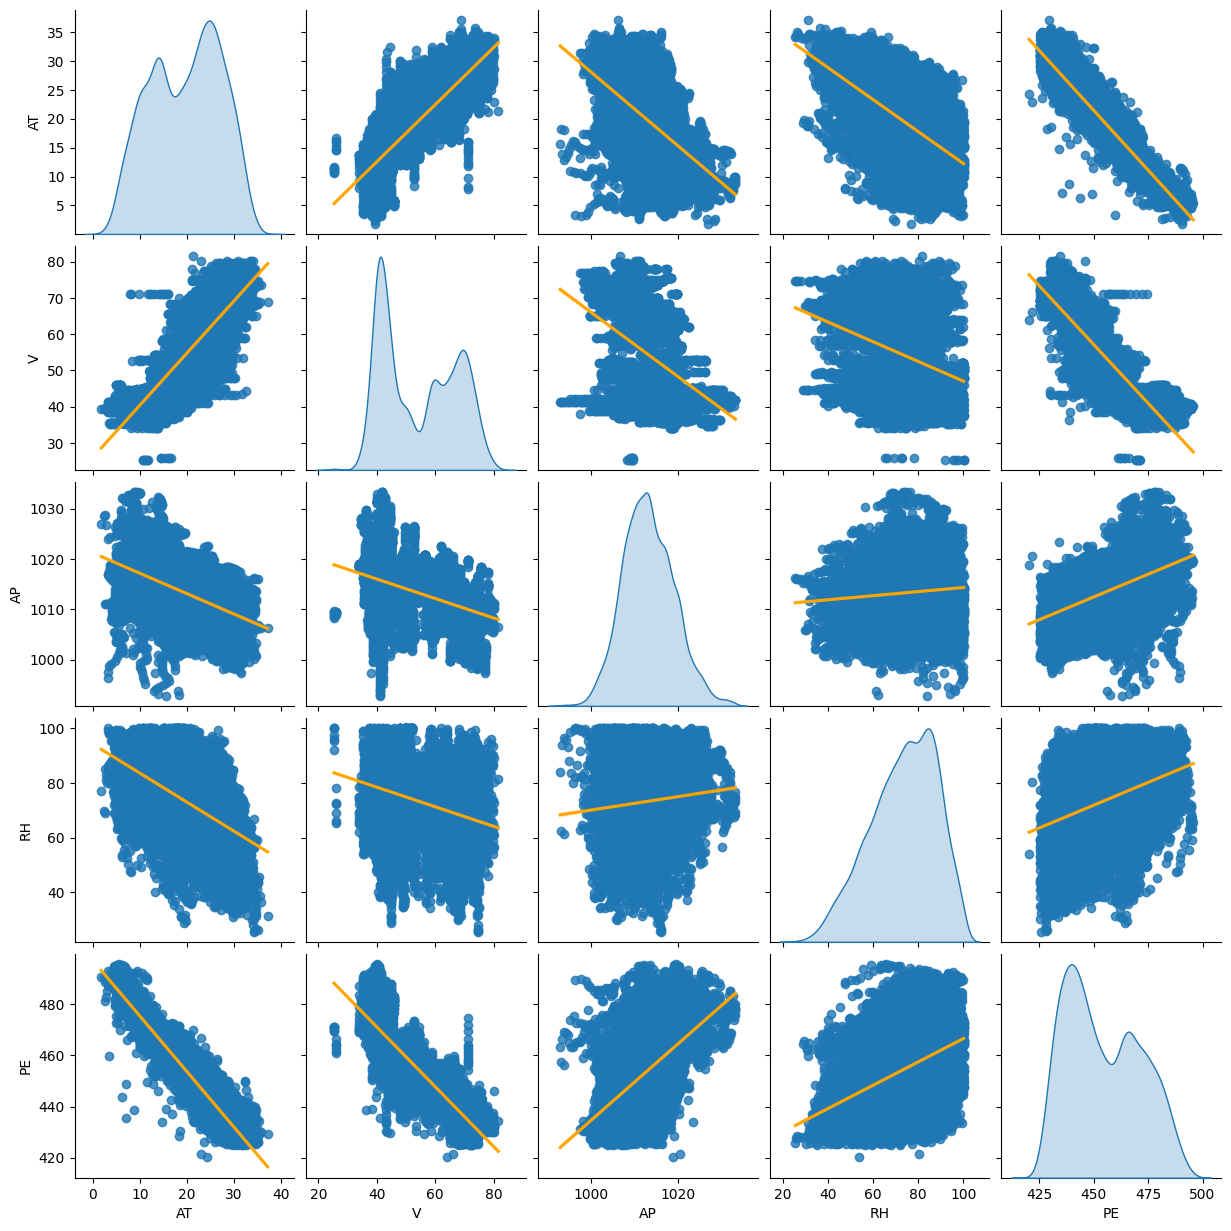

In [25]:
scatterPlot = sns.pairplot(data, diag_kind="kde", kind="reg",
                           plot_kws={'line_kws': {'color': "orange"}})
plt.show()

As we can see in our plot, the PE has positive corr with AP & RH.
Besides, it has negative corr with V & AT.

iii. What are the mean, the median, range, first and third quartiles, and interquartile ranges of each of the variables in the dataset? Summarize them in a table.

In [26]:
print(data.describe())
feature = [column for column in data.columns]
data_range = [(data[column].max() - data[column].min()) for column in data.columns]
interange = [(data[column].quantile(0.25) - data[column].quantile(0.75)) for column in data.columns]

someRange = {
    "feature": feature,
    "range": data_range,
    "interange": interange
}
someRange = pd.DataFrame(someRange)
print(someRange)

                AT            V           AP           RH           PE
count  9568.000000  9568.000000  9568.000000  9568.000000  9568.000000
mean     19.651231    54.305804  1013.259078    73.308978   454.365009
std       7.452473    12.707893     5.938784    14.600269    17.066995
min       1.810000    25.360000   992.890000    25.560000   420.260000
25%      13.510000    41.740000  1009.100000    63.327500   439.750000
50%      20.345000    52.080000  1012.940000    74.975000   451.550000
75%      25.720000    66.540000  1017.260000    84.830000   468.430000
max      37.110000    81.560000  1033.300000   100.160000   495.760000
  feature  range  interange
0      AT  35.30   -12.2100
1       V  56.20   -24.8000
2      AP  40.41    -8.1600
3      RH  74.60   -21.5025
4      PE  75.50   -28.6800


(c) For each predictor, fit a simple linear regression model to predict the response. Describe your results. In which of the models is there a statistically significant association between the predictor and the response? Create some plots to back up your assertions. Are there any outliers that you would like to remove from your data for each of these regression tasks?

In [27]:
train_AT = data["AT"].to_numpy()
train_V  = data["V"].to_numpy()
train_AP = data["AP"].to_numpy()
train_RH = data["RH"].to_numpy()
train_PE = data["PE"].to_numpy()

In [28]:
Threshold = 0.1
coEf_res = {}
def LRM(X, Y, feature):
    trainX = sm.add_constant(X, prepend=False)
    lrm = sm.OLS(Y, trainX)
    lrmR = lrm.fit()
    
    print(lrmR.summary())
    
    outLiers = lrmR.outlier_test()
    outLiers_idx = np.where(outLiers[:, 2] < Threshold)
    
    fig, axes = plt.subplots(figsize = (8, 8))
    axes.scatter(X, Y)
    axes.scatter(X[outLiers_idx], Y[outLiers_idx], marker = "*", label = "Outlier")
    axes.plot(X, lrmR.predict(trainX), "red")
    axes.set_xlabel("x")
    axes.set_ylabel("y")
    axes.legend()
    plt.show()
    
    coEf_res[feature] = lrmR.params
    outLiers_res = np.vstack((X[outLiers_idx], Y[outLiers_idx]))
    return pd.DataFrame(outLiers_res.T, columns=["PE", feature])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 8.510e+04
Date:                Wed, 08 Feb 2023   Prob (F-statistic):               0.00
Time:                        00:04:12   Log-Likelihood:                -21828.
No. Observations:                9568   AIC:                         4.366e+04
Df Residuals:                    9566   BIC:                         4.367e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.4140      0.001   -291.715      0.0

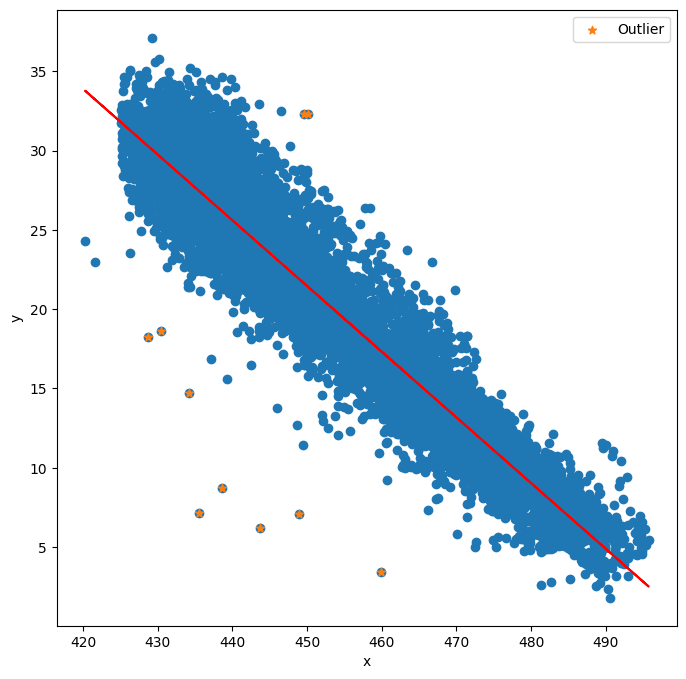

       PE     AT
0  438.63   8.74
1  443.73   6.22
2  434.12  14.69
3  450.13  32.31
4  430.38  18.60
5  448.97   7.06
6  435.58   7.14
7  428.67  18.26
8  449.65  32.31
9  459.86   3.40


In [29]:
outliers = LRM(train_PE, train_AT, "AT")
print(outliers)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                 2.972e+04
Date:                Wed, 08 Feb 2023   Prob (F-statistic):               0.00
Time:                        00:04:48   Log-Likelihood:                -31141.
No. Observations:                9568   AIC:                         6.229e+04
Df Residuals:                    9566   BIC:                         6.230e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.6476      0.004   -172.402      0.0

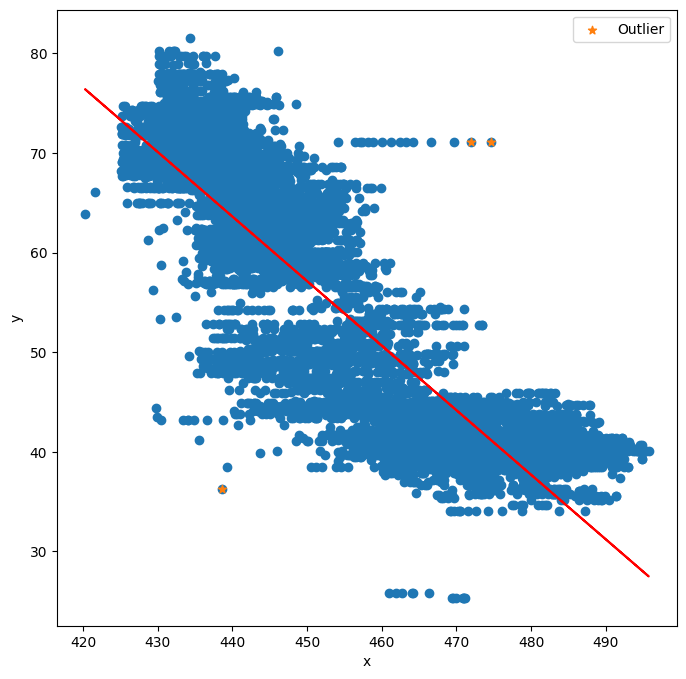

       PE      V
0  471.99  71.14
1  474.66  71.14
2  438.63  36.30


In [30]:
outliers = LRM(train_PE, train_V, "V")
print(outliers)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     3516.
Date:                Wed, 08 Feb 2023   Prob (F-statistic):               0.00
Time:                        00:05:17   Log-Likelihood:                -29124.
No. Observations:                9568   AIC:                         5.825e+04
Df Residuals:                    9566   BIC:                         5.827e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1804      0.003     59.296      0.0

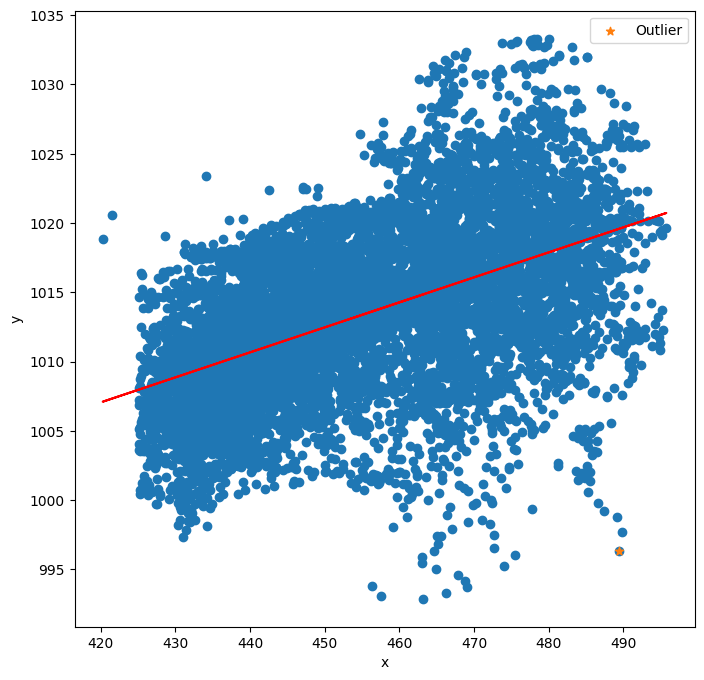

       PE      AP
0  489.38  996.32


In [31]:
outliers = LRM(train_PE, train_AP, "AP")
print(outliers)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     1714.
Date:                Wed, 08 Feb 2023   Prob (F-statistic):               0.00
Time:                        00:05:56   Log-Likelihood:                -38440.
No. Observations:                9568   AIC:                         7.688e+04
Df Residuals:                    9566   BIC:                         7.690e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3335      0.008     41.399      0.0

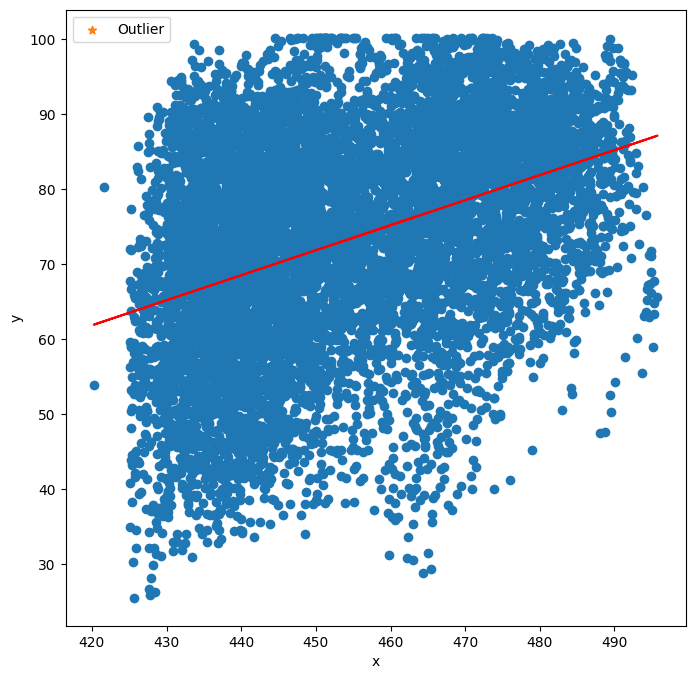

Empty DataFrame
Columns: [PE, RH]
Index: []


In [32]:
outliers = LRM(train_PE, train_RH, "RH")
print(outliers)

No outliers for RH

(d) Fit a multiple regression model to predict the response using all of the predictors. Describe your results. For which predictors can we reject the null hypothesis H0 : βj = 0?

In [33]:
def multiReg(X, Y):
    train_AT, train_V, train_AP, train_RH = X
    train_PE = Y
    train_X = np.vstack((train_AT, train_V, train_AP, train_RH))
    train_X = sm.add_constant(train_X.T, prepend=False)

    lrm = sm.OLS(train_PE, train_X)
    lrmR = lrm.fit()
    coEf_res["multi"] = lrmR.params

    print(lrmR.summary())
multiReg([train_AT, train_V, train_AP, train_RH], train_PE)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Wed, 08 Feb 2023   Prob (F-statistic):               0.00
Time:                        00:06:33   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.9775      0.015   -129.342      0.0

We have p of 0 for all predictor, we can reject all the null hypothesis.

(e) How do your results from 1c compare to your results from 1d? Create a plot displaying the univariate regression coefficients from 1c on the x-axis, and the multiple regression coefficients from 1d on the y-axis. That is, each predictor is displayed as a single point in the plot. Its coefficient in a simple linear regression model is shown on the x-axis, and its coefficient estimate in the multiple linear regression model is shown on the y-axis.

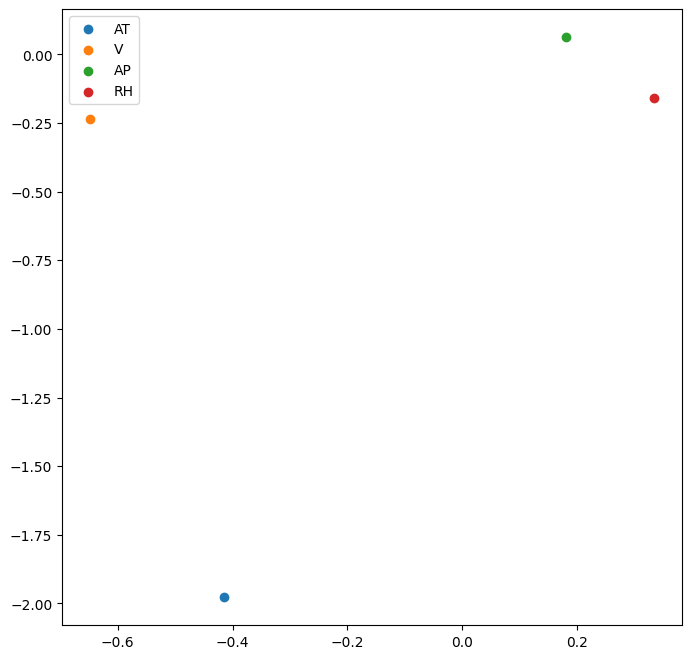

In [34]:
fig, axes = plt.subplots(figsize = (8, 8))
for i, feature in enumerate(["AT", "V", "AP", "RH"]):
    axes.scatter(coEf_res[feature][0], coEf_res["multi"][i], label=feature)
axes.legend()
plt.show()

(f) Is there evidence of nonlinear association between any of the predictors and the response? To answer this question, for each predictor X, fit a model of the form2 Y = β0 + β1X + β2X2 + β3X3 + 

In [35]:
polyRM_res = {}
def polyRM(X, Y, feature):
    poly = PolynomialFeatures(3)
    train_X = poly.fit_transform(np.expand_dims(X, axis=1))
    
    RM = sm.OLS(Y, train_X)
    RMR = RM.fit()
    
    print(RMR.summary())
    polyRM_res[feature] = RMR.params

In [36]:
polyRM(train_AT, train_PE, "AT")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Wed, 08 Feb 2023   Prob (F-statistic):               0.00
Time:                        00:06:33   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        492.7281      0.673    732.248      0.0

P-value are small enough, reject the null hypothesis. This is the evidence of a nonlinear association between AT predictor and response.

In [37]:
polyRM(train_V, train_PE, "V")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                 1.098e+04
Date:                Wed, 08 Feb 2023   Prob (F-statistic):               0.00
Time:                        00:06:34   Log-Likelihood:                -33585.
No. Observations:                9568   AIC:                         6.718e+04
Df Residuals:                    9564   BIC:                         6.721e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        554.1468      9.151     60.557      0.0

P-value are large enough, can not reject the null hypothesis. This is not the evidence of a nonlinear association between AT predictor and response.

In [38]:
polyRM(train_AP, train_PE, "AP")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     1813.
Date:                Wed, 08 Feb 2023   Prob (F-statistic):               0.00
Time:                        00:06:34   Log-Likelihood:                -39184.
No. Observations:                9568   AIC:                         7.837e+04
Df Residuals:                    9565   BIC:                         7.840e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0747      0.009      8.415      0.0

P-value are small enough, reject the null hypothesis. This is the evidence of a nonlinear association between AT predictor and response.

In [39]:
polyRM(train_RH, train_PE, "RH")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     579.2
Date:                Wed, 08 Feb 2023   Prob (F-statistic):               0.00
Time:                        00:06:34   Log-Likelihood:                -39923.
No. Observations:                9568   AIC:                         7.985e+04
Df Residuals:                    9564   BIC:                         7.988e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        468.4135     10.545     44.422      0.0

P-value are small enough, reject the null hypothesis. This is the evidence of a nonlinear association between AT predictor and response.

(g) Is there evidence of association of interactions of predictors with the response? To answer this question, run a full linear regression model with all pairwise interaction terms and state whether any interaction terms are statistically significant. 

In [40]:
formula = 'PE ~ AT*V + AT*AP + AT*RH + V*AP + V*RH + AP*RH + AT + V+ AP + RH'
lrm = smf.ols(formula=formula, data = data)
lrmR = lrm.fit()
print(lrmR.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Wed, 08 Feb 2023   Prob (F-statistic):               0.00
Time:                        00:06:34   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    685.7825     78.640      8.721      0.0

There is evidence of association of interactions of predictors (AT*V, AT*RH, V*AP, V) with the response

If the p-value threshold is 0.05, there is evidence of association of interactions of predictors (AP*RH, AP, RH) with the response

(h) Can you improve your model using possible interaction terms or nonlinear associations between the predictors and response? Train the regression model on a randomly selected 70% subset of the data with all predictors. Also, run a regression model involving all possible interaction terms and quadratic nonlinearities, and remove insignificant variables using p-values (be careful about interaction terms). Test both models on the remaining points and report your train and test MSEs.

In [44]:
random.seed(2023)
# del range
id = [x for x in range(0,9568)]

random.shuffle(id)

size = round(len(data) * 0.7)
train_data = data.iloc[id[:size], :]
test_X = data.iloc[id[size:], :-1]
test_Y = data.iloc[id[size:], -1]

RG_res = {}

In [45]:
from sklearn.metrics import mean_squared_error

def pipline(name, formula, data = [train_data, test_X, test_Y]):
    train_data, test_X, test_Y = data
    lrmR = smf.ols(formula, train_data).fit()
    print(lrmR.summary())
    
    predict_train = lrmR.predict(train_data.iloc[:,:-1])
    predict_test = lrmR.predict(test_X)
    
    eva_train = mean_squared_error(train_data.iloc[:,-1], predict_train)
    eva_test = mean_squared_error(test_Y, predict_test)
    print("For {} model, eva_train is {}, eva_test is {}".format(name, eva_train, eva_test))
    RG_res[name] = [eva_train, eva_test]
    

In [46]:
formula = 'PE ~ AT*V + AT*AP + AT*RH + V*AP + V*RH + AP*RH + AT + V+ AP + RH + np.power(V, 2)+ np.power(AT, 2) +np.power(AP, 2)+np.power(RH, 2)'
pipline("all", formula)


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     7236.
Date:                Wed, 08 Feb 2023   Prob (F-statistic):               0.00
Time:                        00:07:53   Log-Likelihood:                -19219.
No. Observations:                6698   AIC:                         3.847e+04
Df Residuals:                    6683   BIC:                         3.857e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -8640.1205   1483.409     

In [47]:
formula = 'PE ~ AT*V + AT*RH + AP*RH + AP + RH + np.power(AT, 2) +np.power(AP, 2)+np.power(RH, 2)'
pipline("best", formula)

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                 1.012e+04
Date:                Wed, 08 Feb 2023   Prob (F-statistic):               0.00
Time:                        00:07:57   Log-Likelihood:                -19223.
No. Observations:                6698   AIC:                         3.847e+04
Df Residuals:                    6687   BIC:                         3.854e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -1.079e+04   1121.405     

(i) KNN Regression:
i. Perform k-nearest neighbor regression for this dataset using both normalized and raw features. Find the value of k ∈ {1, 2, . . . , 100} that gives you the best fit. Plot the train and test errors in terms of 1/k.

In [48]:
step = 1
k_range = range(1, 101, step)
# k_range = range(8, 0, step)

bestK = []
bestError = []

train_input = train_data.iloc[:,:-1]
train_output = train_data.iloc[:,-1]
test_input = test_X
test_output = test_Y

In [50]:
def KNN(data = [train_input, train_output, test_input, test_output], k_range = k_range):
    train_input, train_output, test_input, test_output = data
    ress = []
    min_mse = float("inf")
    min_K = 0
    for k in k_range:
        knn_model = KNeighborsRegressor(k)
        knn_model.fit(train_input, train_output)
        
        train_pre = knn_model.predict(train_input)
        train_mse = mean_squared_error(train_output, train_pre)
        
        test_pre = knn_model.predict(test_input)
        test_mse = mean_squared_error(test_output, test_pre)
        
        res = {
            "k": k,
            "train_mse": train_mse,
            "test_mse": test_mse
        }
        ress.append(res)
        if test_mse < min_mse:
            min_mse = test_mse
            min_K = k
    print("Best K:")
    k, train_mse, test_mse = min_K, ress[min_K]["train_mse"], ress[min_K]["test_mse"]
    print("K={}\ttrain_mse={}\ttest_mse={}".format(k, train_mse, test_mse))
    return ress

In [54]:
ress = KNN()

Best K:
K=6	train_mse=11.934200211455138	test_mse=16.09329410367631


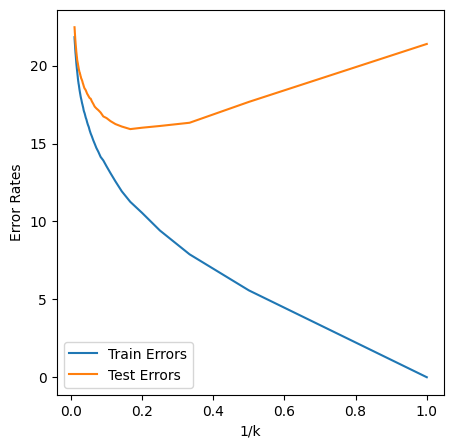

In [58]:
def paint(ress):
    ress = pd.DataFrame(ress)

    fig, axes = plt.subplots(1, 1, figsize=(5,5))
    # plot error_rate fig
    axes.plot(1/ress["k"], ress["train_mse"], label="Train Errors")
    axes.plot(1/ress["k"], ress["test_mse"], label="Test Errors")
    # axes.invert_xaxis()
    axes.set_xlabel("1/k")
    axes.set_ylabel("Error Rates")
    axes.legend()
    plt.show()

paint(ress)

Then, we can use normalize data.

Best K:
K=6	train_mse=11.042755942681639	test_mse=15.125012678660314


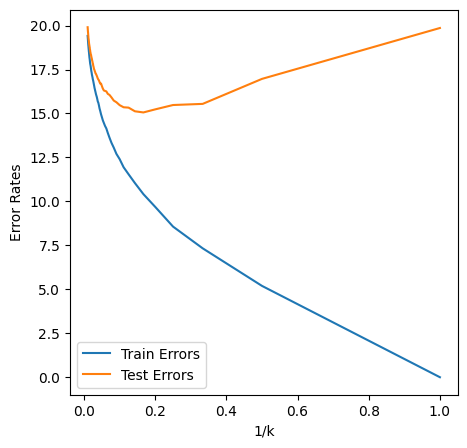

In [60]:
train_input_nom = train_input.apply(lambda line:( line - line.mean()) / np.std(line), axis = 0)
test_input_nom = test_input.apply(lambda line:( line - line.mean()) / np.std(line), axis = 0)
ress = KNN([train_input_nom, train_output, test_input_nom, test_output])

paint(ress)

(j) Compare the results of KNN Regression with the linear regression model that has the smallest test error and provide your analysis.

When we use normalize data, and K = 6, we can get best best result(test_mse=15.125012678660314). It may because the data is not linearly separate as we can see in (b)ii.

### ISLR: 2.4.1
1. For each of parts (a) through (d), indicate whether we would generally expect the performance of a ﬂexible statistical learning method to be better or worse than an inﬂexible method. Justify your answer.

(a) The sample size n is extremely large, and the number of predictors p is small.

(b) The number of predictors p is extremely large, and the number of observations n is small.

(c) The relationship between the predictors and response is highly non-linear.

(d) The variance of the error terms, i.e. σ 2 = Var(), is extremely high.

(a)flexible statistical learning method is better, because the sample size is large and inflexible method will suffurs from underfitting.
(b)unflexible statistical learning method is better, because the number of predictors is large will make flexible method overfitting.
(c)flexible statistical learning method is better, because it is difficult for unflexible approach to learn the non-linear relation.
(d)unflexible statistical learning method is better, because the flexible statistical learning will become overfitting.

### ISLR: 2.4.7
The table below provides a training data set containing six observations, three predictors, and one qualitative response variable.
Suppose we wish to use this data set to make a prediction for Y when X 1 = X 2 = X 3 = 0 using K-nearest neighbors.

(a) Compute the Euclidean distance between each observation and the test point, X 1 = X 2 = X 3 = 0.
(b) What is our prediction with K = 1? Why?
(c) What is our prediction with K = 3? Why?
(d) If the Bayes decision boundary in this problem is highly nonlinear, then would we expect the best value for K to be large or small? Why?

(a)
obs 1: Euclidean distance is: 3
obs 2: Euclidean distance is: 2
obs 3: Euclidean distance is: 3.162
obs 4: Euclidean distance is: 2.236
obs 5: Euclidean distance is: 1.414
obs 6: Euclidean distance is: 1.732

(b) What is our prediction with K = 1? Why?
(c) What is our prediction with K = 3? Why?
(d) If the Bayes decision boundary in this problem is highly non- linear, then would we expect the best value for K to be large or small? Why?

(b)Green. We should choose the nearnest neighbor(5), it is green.
(c)Red. It can be get from the voting of the nearest 3 nodes(2, 5, 6). They have two red node.
(d)It should be small. It will fit linear decision boundary if we use large K.